## Document Classifier

In [1]:
import csv
import pickle
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

<h4>Explore Training Dataset:

In [2]:
labels = []
hashed_text = []
label_dict = {}
word_dict = {}
word_counts_per_row = []
max_row_len = 0
min_row_len = 1e6
bad_row_ctr = 0

# minimum number of words in a row for record to be included in training set
MIN_WORDS = 10

with open('C:\\Users\\Barnwaldo\\Documents\\Labs\\HeavyWater\\shuffled-full-set-hashed.csv', mode='r', encoding='utf-8') as lines:
    for line in lines:
        items = line.split(',')
        
        # create labels dict
        if items[0] in label_dict:
            label_dict[items[0]] += 1
        else:
            label_dict[items[0]] = 1
            
         # create hashed word dict
        text = items[1].split(' ')
        text[-1] = text[-1].rstrip()
        for t in text:
            if t in word_dict:
                word_dict[t] += 1
            else:
                word_dict[t] = 1
        # determine max/min words per row and save word_counts for histogram
        tlen = len(text)
        if tlen < MIN_WORDS:
            bad_row_ctr += 1
        word_counts_per_row.append(tlen)
        if tlen < min_row_len:
            min_row_len = tlen
        if tlen > max_row_len: 
            max_row_len = tlen

        # update labels and hashed_text lists
        labels.append(items[0])
        hashed_text.append(text)
         
print("Total number of data records: {}  {}".format(len(labels), len(hashed_text)))
print("Number of data records < {} words:  {}".format(MIN_WORDS, bad_row_ctr))

print("\nLabels:")
for key, val in label_dict.items():
    print("     {:25s}  --  {}".format(key, val))
num_labels = len(label_dict)
print("Number of Labels:", num_labels)

print("\nWords:")
print("     Number of Words in Dict:", len(word_dict))
print("     Max words in hashed text entry:", max_row_len)
print("     Min words in hashed text entry:", min_row_len)

Total number of data records: 62204  62204
Number of data records < 10 words:  146

Labels:
     DELETION OF INTEREST       --  4826
     RETURNED CHECK             --  749
     BILL                       --  18968
     POLICY CHANGE              --  10627
     CANCELLATION NOTICE        --  9731
     DECLARATION                --  968
     CHANGE ENDORSEMENT         --  889
     NON-RENEWAL NOTICE         --  624
     BINDER                     --  8973
     REINSTATEMENT NOTICE       --  4368
     EXPIRATION NOTICE          --  734
     INTENT TO CANCEL NOTICE    --  229
     APPLICATION                --  229
     BILL BINDER                --  289
Number of Labels: 14

Words:
     Number of Words in Dict: 1037935
     Max words in hashed text entry: 9076
     Min words in hashed text entry: 1


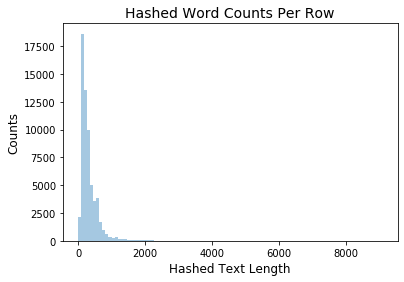

In [3]:
sns.distplot(word_counts_per_row, kde=False, bins=100)
plt.title('Hashed Word Counts Per Row', fontsize=14)
plt.xlabel('Hashed Text Length', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

<h4>Preprocess data</h4>
<ol>
    <li>Create Tokenization and Label Index Dicts and save to files</li>
    <li>Tokenize each row in training dataset</li>
    <li>Truncate/Pad each row to fixed length</li>
    <li>Create One Hot Labels Vector per Row for Training BCE for each label</li>
</ol>


In [4]:
# (1) Create Tokenization Index Dict and save to file
tokenizer = Tokenizer(lower=False, filters='', num_words=None)     # change num_words to int value to shorten the number of words in tokenized dict
tokenizer.fit_on_texts([j for sub in hashed_text for j in sub]) 
vocabulary = tokenizer.get_config()

# write Tokenizer to pickle file and then read back - tokenizer pickle file is part of saved model (preprocessing)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# (1) Create Label Index Dict and save to file
label_indexer = {}
label_list = [key for key in label_dict]
for idx, label in enumerate(label_list):
    label_indexer[label] = idx
    
# write label_indexer to file in json and then read back - label_indexer is part of trained model (preprocessing)
with open('label_indexer.json', 'w') as jsonfile:
    json.dump(label_indexer, jsonfile)
    
with open('label_indexer.json') as json_file:
    label_indexer = json.load(json_file)   

In [5]:
# (2) Tokenize each row in training dataset
raw_tokens = []
max_index = 0
for text in hashed_text:
    token_lists = tokenizer.texts_to_sequences(text)
    temp = [j for sub in token_lists for j in sub]
    raw_tokens.append(temp)
    if len(temp) == 0: 
        continue
    max_token_index = max(temp)
    if max_token_index > max_index:
        max_index = max_token_index

print("Number of Entries BEFORE bad row removal: Hashed Text = {} -- Raw Tokens = {} -- Max Token Index = {} ".format(len(hashed_text), len(raw_tokens), max_index))

# remove bad rows (with word counts < MIN_WORDS)
bad_row_index = []
for idx in range(len(raw_tokens)):
    if len(raw_tokens[idx]) < MIN_WORDS:
        bad_row_index.append(idx)

for idx in bad_row_index:
    labels.pop(idx)
    hashed_text.pop(idx)
    raw_tokens.pop(idx)
    
print("Number of Entries AFTER bad row removal: Hashed Text = {} -- Raw Tokens = {} -- Labels = {} ".format(len(hashed_text), len(raw_tokens), len(labels)))

Number of Entries BEFORE bad row removal: Hashed Text = 62204 -- Raw Tokens = 62204 -- Max Token Index = 1037934 
Number of Entries AFTER bad row removal: Hashed Text = 62058 -- Raw Tokens = 62058 -- Labels = 62058 


In [6]:
# (3) Truncate/Pad each row to fixed length; change to Numpy array
MAX_LEN = 200
X = np.empty((len(raw_tokens), MAX_LEN), dtype=np.int32)

for idx in range(len(raw_tokens)):
    tok_length = len(raw_tokens[idx])
    
    # Pad first, keep last
    # if tok_length < MAX_LEN:
    #     X[idx] = np.concatenate((np.zeros(MAX_LEN - tok_length, dtype=np.int32), raw_tokens[idx]), axis=0).astype(np.int32)
    # else:
    #     X[idx] = np.array(raw_tokens[idx][tok_length - MAX_LEN:], dtype=np.int32)
    
    # Pad last, keep first    
    if tok_length < MAX_LEN:
        X[idx] = np.concatenate((raw_tokens[idx], np.zeros(MAX_LEN - tok_length, dtype=np.int32)), axis=0).astype(np.int32)
    else:
        X[idx] = np.array(raw_tokens[idx][:MAX_LEN], dtype=np.int32)

# for i in range(5):
#     print("************* Index: {} -- Length: {} **************".format(i, len(X[i])))
#     print(X[i])
#     print("-------------------------------")
print("Number of Preprocessed Text Entries = {}".format(len(X)))

Number of Preprocessed Text Entries = 62058


In [7]:
# (4) Create One Hot Label Vectors
y = np.zeros((len(labels), len(label_list)), dtype=np.int32)
for i in range(len(labels)):
    y[i, label_indexer[labels[i]]] = 1
    
# for i in range(20):
#     print("************* Index: {} -- Length: {} **************".format(i, len(y[i])))
#     print(labels[i], label_indexer[labels[i]], y[i])
#     print("-------------------------------")
print("Number of Label Vector Entries = {}".format(len(y)))

Number of Label Vector Entries = 62058


<h4>Define Models</h4>
<ol>
    <li>Separable (1d) CNN model</li>
    <li>Bidirectional LSTM model</li>
</ol>

In [8]:
from tensorflow.keras import models, initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Embedding, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, ReLU

# (1) Separable (1d) CNN Model 
def sepcnn(max_word_index, num_feature, num_class, embedding_dim=100, kernel_size=3, pool_size=3, filters=64, dropout=0.1, activation='sigmoid'):
    model = models.Sequential()
    # Embedding layer. 
    model.add(Embedding(max_word_index, embedding_dim, input_length=num_feature))
    # CNN Block 1
    model.add(SeparableConv1D(filters=filters, kernel_size=kernel_size, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SeparableConv1D(filters=filters, kernel_size=kernel_size, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # CNN Block 2
    model.add(SeparableConv1D(filters=filters, kernel_size=kernel_size, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SeparableConv1D(filters=filters, kernel_size=kernel_size, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # CNN Block 3
    model.add(SeparableConv1D(filters=filters * 2, kernel_size=kernel_size, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SeparableConv1D(filters=filters * 2, kernel_size=kernel_size, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(GlobalAveragePooling1D())
    # Fully Connected Layer
    model.add(Dropout(rate=dropout))
    model.add(Dense(num_class, activation=activation))
    # try using different optimizers and different optimizer configs
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
from tensorflow.keras.layers import LSTM, Bidirectional

# (2) Bidirectional LSTM
def bilstm(max_word_index, num_feature, num_class, embedding_dim=100, dropout=0.1, activation='sigmoid'):
    model = models.Sequential()
    # Embedding layer. 
    model.add(Embedding(max_word_index, embedding_dim, input_length=num_feature))
    # BiLSTM layer
    model.add(Bidirectional(LSTM(64)))
    # Fully Connected Layer
    model.add(Dropout(dropout))
    model.add(Dense(num_class, activation=activation))
    # try using different optimizers and different optimizer configs
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Plot Model History
def plot(epochs, history):
    xdata = list(range(1, epochs + 1))
    plt.plot(xdata, history['accuracy'],      label='Train Acc')
    plt.plot(xdata, history['val_accuracy'],  label='Val Acc')
    plt.plot(xdata, history['loss'],     label='Train Loss')
    plt.plot(xdata, history['val_loss'], label='Val Loss')
 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    plt.show()

<h4> Train Separable CNN Model

Train on 49646 samples, validate on 12412 samples
Epoch 1/5
49646/49646 [==============================] - 999s 20ms/sample - loss: 0.1026 - accuracy: 0.9652 - val_loss: 0.0694 - val_accuracy: 0.9771
Epoch 2/5
49646/49646 [==============================] - 993s 20ms/sample - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.0742 - val_accuracy: 0.9751
Epoch 3/5
49646/49646 [==============================] - 995s 20ms/sample - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.1020 - val_accuracy: 0.9728
Epoch 4/5
49646/49646 [==============================] - 992s 20ms/sample - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.1076 - val_accuracy: 0.9732
Epoch 5/5
49646/49646 [==============================] - 994s 20ms/sample - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.1039 - val_accuracy: 0.9745

SEP_CNN TRAINING AND VALIDATION COMPLETE... elapsed time: 27262.296875 sec


{'loss': [0.10263060000275055, 0.03874549539029269, 0.018807949615269194, 0.011841409910482516, 0.008721442145093555], 'ac

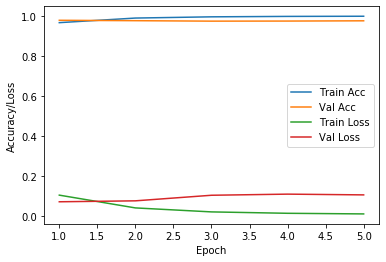

In [11]:
from sklearn.model_selection import train_test_split
import time

seed = 42
np.random.seed(seed)

EPOCHS = 5
BATCH_SIZE = 50

start_time = time.process_time()
# Split training data 80/20 train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
cnn_model = sepcnn(max_index + 1, MAX_LEN, num_labels)
history = cnn_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
print('\nSEP_CNN TRAINING AND VALIDATION COMPLETE... elapsed time: {} sec'.format(time.process_time() - start_time))

# cnn_model.save('doc_classifier_sep_cnn.h5')
print("\n")
print(history.history)
print("\n")
plot(EPOCHS, history.history)

In [12]:
from sklearn.model_selection import GridSearchCV, KFold

start_time = time.process_time()
# Test with K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
    cnn_model.fit(X[train], y[train], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    scores = cnn_model.evaluate(X[test], y[test], verbose=0)
    print("{0:s} : {1:.2f}".format(cnn_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("{0:.2f} (+/-{1:.2f})".format(np.mean(cvscores), np.std(cvscores)))
print('\nSEP_CNN K-FOLD CROSS VALIDATION COMPLETE... elapsed time: {} sec'.format(time.process_time() - start_time))

accuracy : 97.54
accuracy : 99.70
accuracy : 99.80
accuracy : 99.80
accuracy : 99.80
99.33 (+/-0.89)

SEP_CNN K-FOLD CROSS VALIDATION COMPLETE... elapsed time: 135766.375 sec


<h4>Train BiLSTM Model

Train on 49646 samples, validate on 12412 samples
Epoch 1/5
49646/49646 [==============================] - 990s 20ms/sample - loss: 0.1527 - accuracy: 0.9481 - val_loss: 0.1000 - val_accuracy: 0.9650
Epoch 2/5
49646/49646 [==============================] - 989s 20ms/sample - loss: 0.0793 - accuracy: 0.9737 - val_loss: 0.0764 - val_accuracy: 0.9735
Epoch 3/5
49646/49646 [==============================] - 988s 20ms/sample - loss: 0.0482 - accuracy: 0.9851 - val_loss: 0.0733 - val_accuracy: 0.9756
Epoch 4/5
49646/49646 [==============================] - 993s 20ms/sample - loss: 0.0303 - accuracy: 0.9911 - val_loss: 0.0787 - val_accuracy: 0.9748
Epoch 5/5
49646/49646 [==============================] - 991s 20ms/sample - loss: 0.0206 - accuracy: 0.9940 - val_loss: 0.0853 - val_accuracy: 0.9756

BiLSTM TRAINING AND VALIDATION COMPLETE... elapsed time: 27113.546875 sec


{'loss': [0.15267452746851826, 0.07933944557901379, 0.04822171697596335, 0.03032950353297136, 0.020559425109008253], 'accur

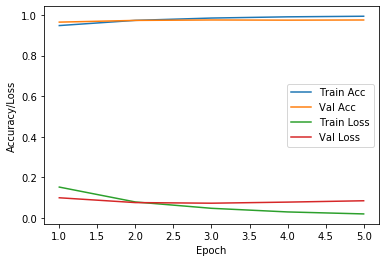

In [13]:
EPOCHS = 5
BATCH_SIZE = 50

start_time = time.process_time()
lstm_model = bilstm(max_index + 1, MAX_LEN, num_labels)
history = lstm_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
print('\nBiLSTM TRAINING AND VALIDATION COMPLETE... elapsed time: {} sec'.format(time.process_time() - start_time))

# lstm_model.save('doc_classifier_bilstm.h5')
print("\n")
print(history.history)
print("\n")
plot(EPOCHS, history.history)

In [14]:
start_time = time.process_time()
# Test with K-fold cross validation
cvscores = []
for train, test in kfold.split(X, y):
    lstm_model.fit(X[train], y[train], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    scores = lstm_model.evaluate(X[test], y[test], verbose=0)
    print("{0:s} : {1:.2f}".format(lstm_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("{0:.2f} (+/-{1:.2f})".format(np.mean(cvscores), np.std(cvscores)))
print('\nBiLSTM K-FOLD CROSS VALIDATION COMPLETE... elapsed time: {} sec'.format(time.process_time() - start_time))

accuracy : 97.34
accuracy : 99.75
accuracy : 99.82
accuracy : 99.82
accuracy : 99.82
99.31 (+/-0.99)

BiLSTM K-FOLD CROSS VALIDATION COMPLETE... elapsed time: 135371.015625 sec
